# Study 2 – Descriptive Dataset Analysis
This notebook characterises the dataset used in this thesis at patient, recording 
and seizure level. It ensures transparency in the structure, quality and distribution 
of the available ECG + annotation data prior to further SQI/HRV analysis.

In [1]:
import sys
import jinja2
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


PROJECT_ROOT = Path.cwd()
SRC_ROOT = PROJECT_ROOT / "src"
if str(SRC_ROOT) not in sys.path:
    sys.path.append(str(SRC_ROOT))

from hrv_epatch.plots.plotstyle import set_project_style, palette
from hrv_epatch.plots.seizure_gantt import plot_gantt_from_index
from hrv_epatch.dataset.summary import (
    build_patient_summary,
    compute_within_recording_isi,
    compute_dataset_overview,
    summarise_isi,
)

set_project_style()
PROJECT_ROOT, SRC_ROOT

# from hrv_epatch.dataset.loader import iter_recordings
# from hrv_epatch.dataset.naming import parse_recording_key
# from hrv_epatch.dataset.annotations import load_annotations   # for debugging if needed
# from hrv_epatch.dataset.seizures import SeizureEvent, build_seizure_events_from_df
# from hrv_epatch.plots.seizure_gantt import plot_gantt_from_index
# from src.hrv_epatch.plots.plotstyle import set_project_style, palette


(WindowsPath('c:/Users/kvjkv/.vscode/Epilepsy_MasterThesis'),
 WindowsPath('c:/Users/kvjkv/.vscode/Epilepsy_MasterThesis/src'))

## 1. Load dataset (TDMS + annotations from 01_build)

In [2]:
OUT_DIR = Path(r"E:\Speciale - Results\Datastruct")

df_rec = pd.read_csv(
    OUT_DIR / "recordings_index.csv",
    parse_dates=["recording_start", "recording_end"],
)

df_evt = pd.read_csv(
    OUT_DIR / "seizure_events.csv",
    parse_dates=["absolute_start", "absolute_end"],
)
# Sanity check
df_rec.head(), df_evt.head()


# Create copies to avoid unintentional modifications
df_rec_sum = df_rec.copy()
df_evt_sum = df_evt.copy()

## 2 Dataset-overview (Key metrics)

In [3]:
df_overview = compute_dataset_overview(df_rec, df_evt)
df_overview

print(df_overview.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{lr}
\toprule
Metric & Value \\
\midrule
Patients & 43.00 \\
Enrollments & 50.00 \\
Recordings & 72.00 \\
Total hours & 3264.03 \\
Total seizures & 149.00 \\
Median rec. duration (h) & 45.55 \\
IQR rec. duration (h) & 9.04 \\
\bottomrule
\end{tabular}



## 3 Gantt-figur

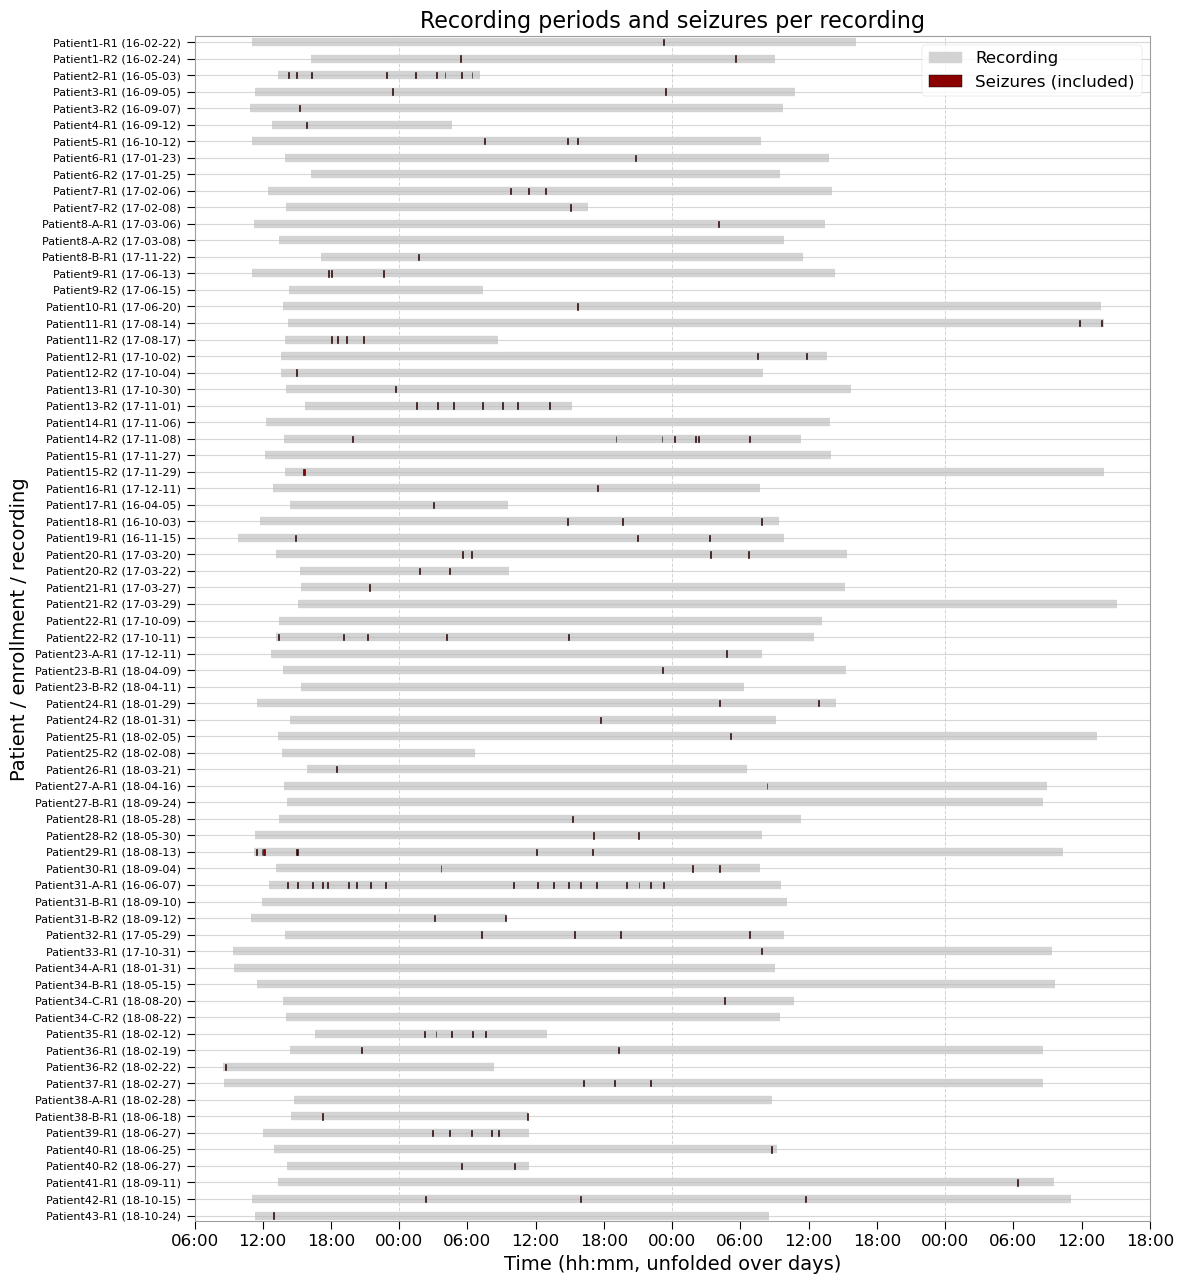

In [11]:
fig, ax = plot_gantt_from_index(df_rec, df_evt, max_hours=96, x_start_hour=6, x_end_hour=90, row_spacing=1.3, bar_height=0.5, figsize=(12, 13))
fig.savefig(OUT_DIR / "study2_gantt_overview.png", dpi=500, bbox_inches="tight")

## 4 Patient-level summary
Total hours, number of recordings, number of seizures etc.

In [ ]:
df_patient_summary = build_patient_summary(df_rec, df_evt)
# print(df_patient_summary)

print(df_patient_summary.to_latex(index=False, float_format="%.2f"))

    Patient Enrollment  Recordings  Total_hours  Total_seizures  \
0         1          -           2    93.843264             3.0   
1         2          -           1    17.745764             9.0   
2         3          -           2    94.395694             3.0   
3         4          -           1    15.812501             1.0   
4         5          -           1    44.737569             3.0   
5         6          -           2    89.010694             1.0   
6         7          -           2    76.141528             4.0   
7         8          a           2    94.566319             1.0   
8         8          b           1    42.335347             1.0   
9         9          -           2    68.245486             3.0   
10       10          -           1    71.999861             1.0   
11       11          -           2    90.496597             6.0   
12       12          -           2    90.373473             3.0   
13       13          -           2    73.168056             8.

# 4. A Total recording time for each patient/enrollment

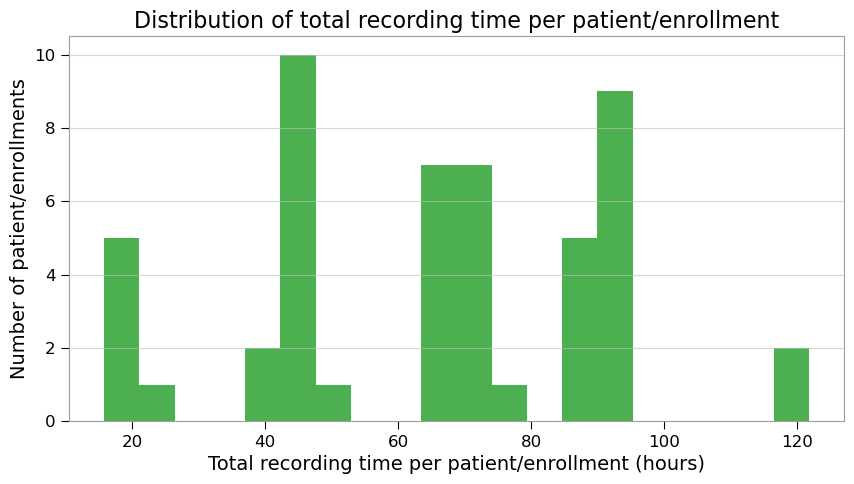

In [6]:
total_hours_pat = df_patient_summary["Total_hours"]

plt.figure(figsize=(10, 5))
plt.hist(total_hours_pat, bins=20, color=palette["primary"])
plt.xlabel("Total recording time per patient/enrollment (hours)")
plt.ylabel("Number of patient/enrollments")
plt.title("Distribution of total recording time per patient/enrollment")

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()


## 5 Recording duration distribution

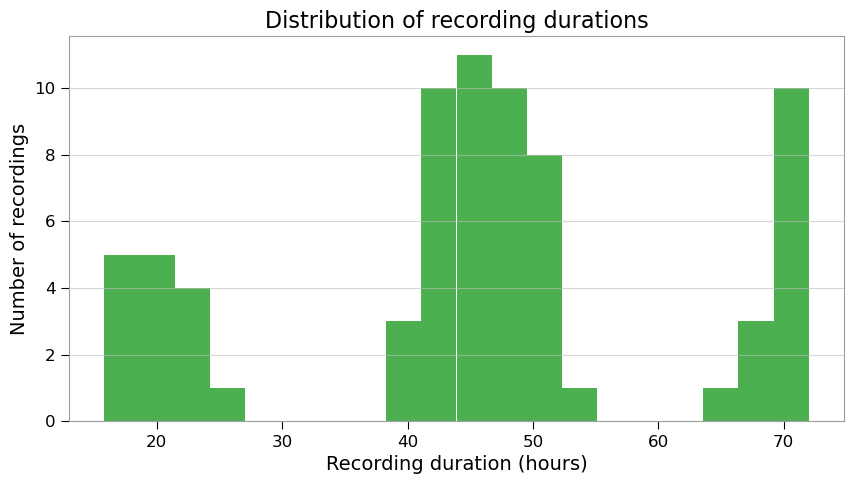

In [7]:
dur_hours = df_rec["rec_duration_s"] / 3600.0

plt.figure(figsize=(10, 5))
plt.hist(dur_hours, bins=20, color=palette["primary"])
plt.xlabel("Recording duration (hours)")
plt.ylabel("Number of recordings")
plt.title("Distribution of recording durations")

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()

## 6 Seizures pr. recording & pr. patient

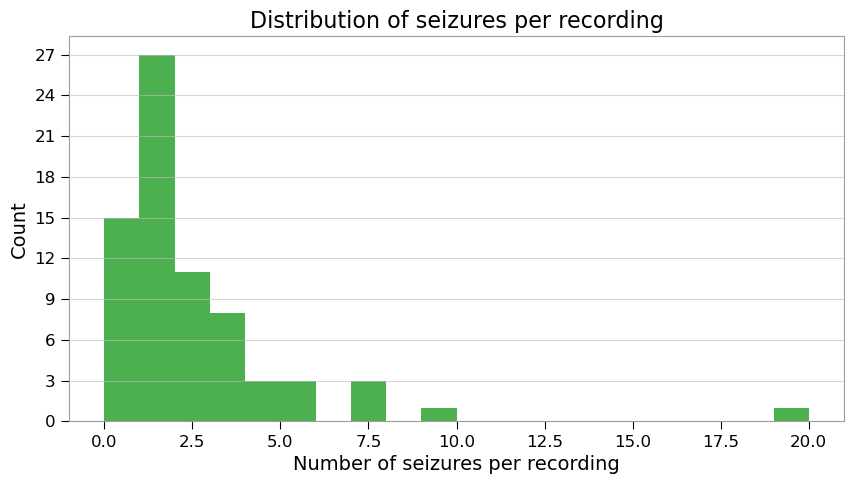

In [8]:
# Seizures per recording
seiz_per_rec = (
    df_evt
    .groupby("recording_uid")["seizure_id"]
    .count()
    .reindex(df_rec["recording_uid"], fill_value=0)
)

plt.figure(figsize=(10, 5))
plt.hist(seiz_per_rec, bins=range(0, int(seiz_per_rec.max()) + 2), color=palette["primary"])
plt.xlabel("Number of seizures per recording")
plt.ylabel("Count")
plt.title("Distribution of seizures per recording")

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()

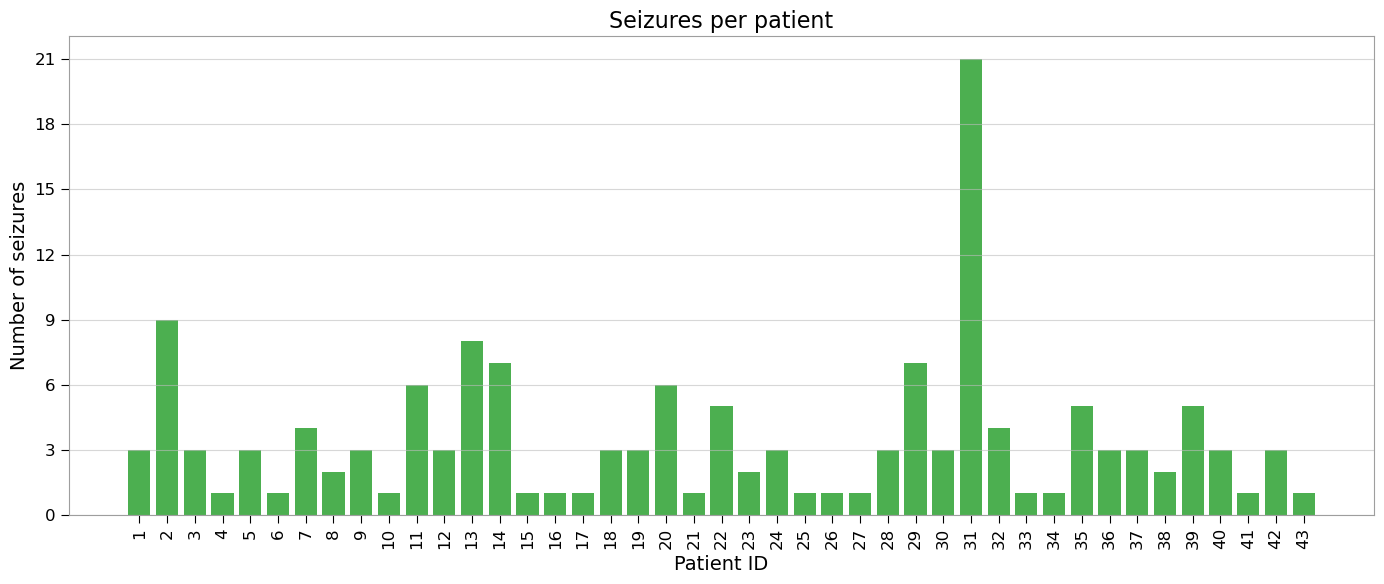

In [9]:
# Seizures per patient
seiz_per_patient = df_evt.groupby("patient_id")["seizure_id"].count()

plt.figure(figsize=(14, 6))
plt.bar(seiz_per_patient.index.astype(str), seiz_per_patient.values, color=palette["primary"])
plt.xlabel("Patient ID")
plt.ylabel("Number of seizures")
plt.title("Seizures per patient")
plt.xticks(rotation=90)

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


In [10]:
df_evt.columns


Index(['recording_uid', 'patient_id', 'enrollment_id', 'recording_id',
       'seizure_id', 't0', 't1', 'duration_s', 'absolute_start',
       'absolute_end'],
      dtype='object')

## 7 Seizure duration distribution

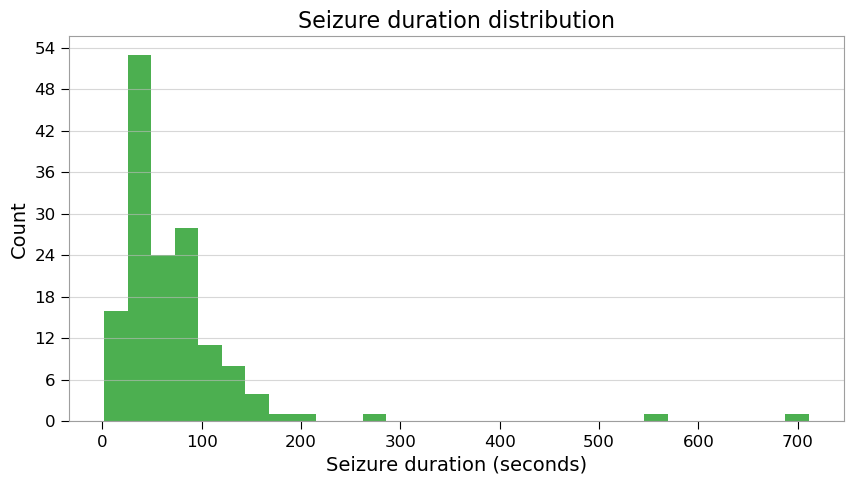

In [11]:
plt.figure(figsize=(10, 5))
plt.hist(df_evt["duration_s"], bins=30, color=palette["primary"])
plt.xlabel("Seizure duration (seconds)")
plt.ylabel("Count")
plt.title("Seizure duration distribution")

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=False))

plt.show()


## 8 Time-of-day distribution for seizures

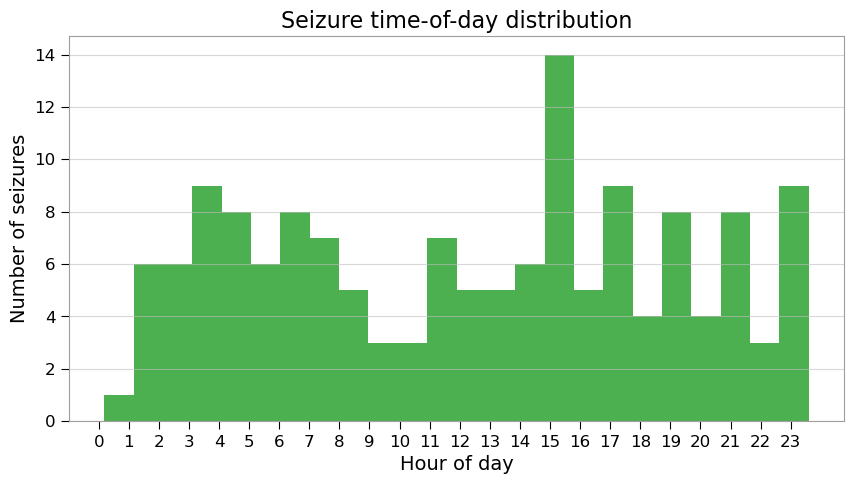

In [12]:
df_evt["hour_of_day"] = (
    df_evt["absolute_start"].dt.hour
    + df_evt["absolute_start"].dt.minute / 60
)

plt.figure(figsize=(10, 5))
plt.hist(df_evt["hour_of_day"], bins=24, color=palette["primary"])
plt.xlabel("Hour of day")
plt.ylabel("Number of seizures")
plt.title("Seizure time-of-day distribution")
plt.xticks(range(0, 24))

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()


## 9 Within-recording ISI + stats

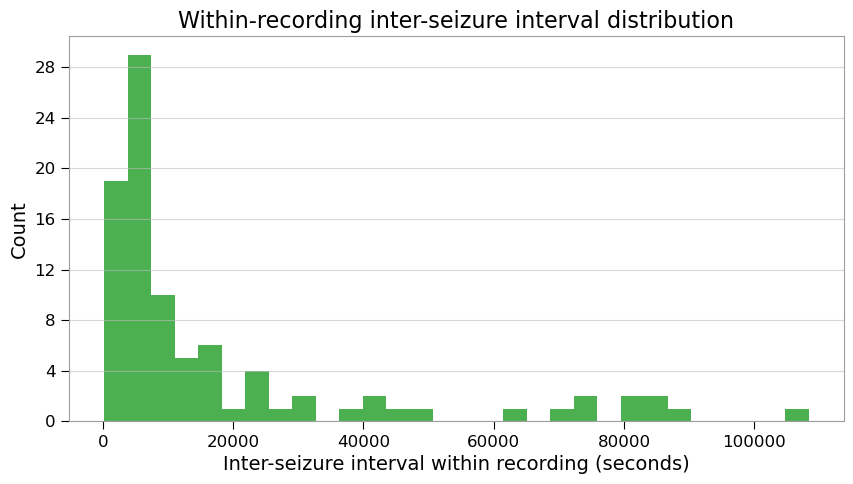

\begin{tabular}{lr}
\toprule
Metric & Value \\
\midrule
n_intervals & 92.00 \\
mean (s) & 18327.05 \\
median (s) & 6808.50 \\
IQR (s) & 14453.00 \\
min (s) & 206.00 \\
max (s) & 108365.00 \\
\bottomrule
\end{tabular}



In [13]:
isi_within = compute_within_recording_isi(df_evt)
len(isi_within)

plt.figure(figsize=(10, 5))
plt.hist(isi_within, bins=30, color=palette["primary"])
plt.xlabel("Inter-seizure interval within recording (seconds)")
plt.ylabel("Count")
plt.title("Within-recording inter-seizure interval distribution")

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()

df_isi_stats = summarise_isi(isi_within)
df_isi_stats

print(df_isi_stats.to_latex(index=False, float_format="%.2f"))

## 10 Export outputs

In [14]:
STUDY2_OUT = OUT_DIR / "_analysis" / "study2_outputs"
STUDY2_OUT.mkdir(parents=True, exist_ok=True)

df_overview.to_csv(STUDY2_OUT / "dataset_overview.csv", index=False)
df_patient_summary.to_csv(STUDY2_OUT / "patient_summary.csv", index=False)
df_isi_stats.to_csv(STUDY2_OUT / "isi_within_stats.csv", index=False)

print("Saved Study2 outputs to:", STUDY2_OUT)


Saved Study2 outputs to: E:\Speciale - Results\Datastruct\_analysis\study2_outputs


In [15]:
from hrv_epatch.dataset.segments import build_segment_index


In [16]:
SEG_WIN_S = 60  # Or 120 if wanting less segments

df_seg = build_segment_index(df_rec, df_evt, window_s=SEG_WIN_S)
df_seg.head(), len(df_seg)


(   segment_id  patient_id enrollment_id  recording_uid       segment_start  \
 0           0           1           NaN              0 2016-02-22 11:04:14   
 1           1           1           NaN              0 2016-02-22 11:05:14   
 2           2           1           NaN              0 2016-02-22 11:06:14   
 3           3           1           NaN              0 2016-02-22 11:07:14   
 4           4           1           NaN              0 2016-02-22 11:08:14   
 
           segment_end     label  
 0 2016-02-22 11:05:14  baseline  
 1 2016-02-22 11:06:14  baseline  
 2 2016-02-22 11:07:14  baseline  
 3 2016-02-22 11:08:14  baseline  
 4 2016-02-22 11:09:14  baseline  ,
 195806)

In [17]:
seg_counts = df_seg["label"].value_counts()
seg_counts


label
baseline    195490
seizure        316
Name: count, dtype: int64

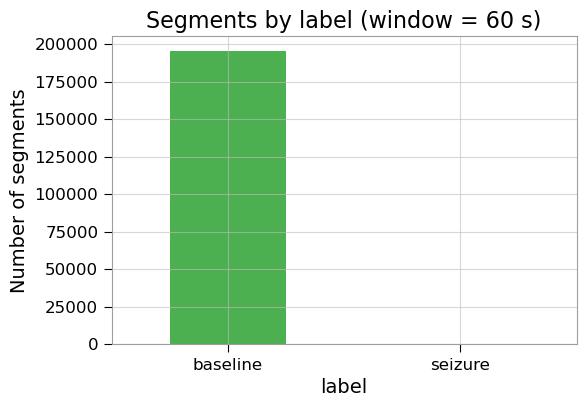

In [18]:
plt.figure(figsize=(6,4))
seg_counts.plot(kind="bar", color=palette["primary"])
plt.ylabel("Number of segments")
plt.title(f"Segments by label (window = {SEG_WIN_S} s)")
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Segments pr label (globalt)
seg_counts = (
    df_seg
    .groupby("label")
    .size()
    .rename("n_segments")
    .reset_index()
)

# Percentage
total_segments = seg_counts["n_segments"].sum()
seg_counts["fraction"] = seg_counts["n_segments"] / total_segments
seg_counts["percent"] = 100 * seg_counts["fraction"]

seg_counts


In [ ]:
plt.figure(figsize=(4, 4))
plt.bar(seg_counts["label"], seg_counts["n_segments"])
plt.ylabel("Number of 60 s segments")
plt.title("Global segment count by label")
plt.tight_layout()
plt.show()

In [19]:
seg_per_patient = (
    df_seg
    .groupby(["patient_id", "label"])["segment_id"]
    .count()
    .unstack(fill_value=0)
    .rename(columns={"baseline": "n_baseline_seg", "seizure": "n_seizure_seg"})
)

seg_per_patient.head()


label,n_baseline_seg,n_seizure_seg
patient_id,,
1,5626,4
2,1051,13
3,5660,3
4,947,1
5,2677,7


In [20]:
seg_per_patient["seizure_fraction"] = (
    seg_per_patient["n_seizure_seg"] /
    (seg_per_patient["n_baseline_seg"] + seg_per_patient["n_seizure_seg"])
)
seg_per_patient.head()


label,n_baseline_seg,n_seizure_seg,seizure_fraction
patient_id,,,
1,5626,4,0.000710
2,1051,13,0.012218
3,5660,3,0.000530
4,947,1,0.001055
5,2677,7,0.002608


### Segment distribution per patient

Next, we summarise the number of 60 s segments per label at patient level,
and convert these counts into hours of data per label.
This highlights between-patient differences in total monitored time and
seizure burden.

In [ ]:
SEGMENT_LEN_S = 60.0  # samme som da vi byggede segment_index

# Antal segmenter pr. patient og label
seg_per_patient = (
    df_seg
    .groupby(["patient_id", "label"])
    .size()
    .rename("n_segments")
    .reset_index()
)

# Tilføj varighed (sekunder og timer)
seg_per_patient["duration_s"] = seg_per_patient["n_segments"] * SEGMENT_LEN_S
seg_per_patient["duration_h"] = seg_per_patient["duration_s"] / 3600.0

seg_per_patient.head()


In [ ]:
# Pivot: én række pr. patient, kolonner for hver label (antal segmenter)
seg_counts_wide = (
    seg_per_patient
    .pivot(index="patient_id", columns="label", values="n_segments")
    .fillna(0)
    .astype(int)
)

# Tilsvarende i timer
seg_hours_wide = (
    seg_per_patient
    .pivot(index="patient_id", columns="label", values="duration_h")
    .fillna(0.0)
)

display(seg_counts_wide.head())
display(seg_hours_wide.head())


In [ ]:
# Summarise pr. patient: total recording time og seizures-baseline balance
patient_seg_summary = seg_hours_wide.copy()
patient_seg_summary["total_hours"] = patient_seg_summary.sum(axis=1)

# Andel af tid i seizure-vinduer, hvis kolonnen findes
if "seizure" in patient_seg_summary.columns:
    patient_seg_summary["seizure_frac"] = (
        patient_seg_summary["seizure"] / patient_seg_summary["total_hours"]
    )
else:
    patient_seg_summary["seizure_frac"] = 0.0

patient_seg_summary.head()


In [ ]:
labels = seg_hours_wide.columns.tolist()

plt.figure(figsize=(8, 4))

bottom = np.zeros(len(seg_hours_wide))
x = np.arange(len(seg_hours_wide.index))

for lbl in labels:
    vals = seg_hours_wide[lbl].to_numpy()
    plt.bar(x, vals, bottom=bottom, label=lbl)
    bottom += vals

plt.xticks(x, [f"P{pid:02d}" for pid in seg_hours_wide.index], rotation=45)
plt.ylabel("Hours of 60 s segments")
plt.title("Segment time per patient by label")
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
SEG_OUT = OUT_DIR / f"segment_index_{SEG_WIN_S}s.csv"
df_seg.to_csv(SEG_OUT, index=False)
SEG_OUT


WindowsPath('E:/Speciale - Results/Datastruct/segment_index_60s.csv')